In case you are using google colab, uncomment the following cell, and modify the ```notebook_dir``` variable to contain the directory this notebook is in. It will automatically download the .py files needed for this assignment

In [2]:
# # Change the following  line to the directory this notebook is (if using colab)
# # In case you do not know the path, open the file navigator on the left in colab
# # Find the folder containing this notebook, then press on the three dots --> copy path
notebook_dir = "/content/drive/MyDrive/Colab Notebooks/"

In [3]:
# # UNCOMMENT IF USING COLAB
from google.colab import drive
import requests
drive.mount('/content/drive')
import sys
import os
sys.path.insert(0, notebook_dir)
os.chdir(notebook_dir)
symco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"
crpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"
r_s = requests.get(symco, allow_redirects=True)
r_c = requests.get(crpt, allow_redirects=True)
with open('symconv.py', 'wb') as f:
    f.write(r_s.content)
with open('carpet.py', 'wb') as f:
    f.write(r_c.content)

Mounted at /content/drive


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import io
import requests

import symconv as sc
from carpet import show_carpet, oh_to_label

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from tqdm import tqdm

In [5]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive.

    Input:
    url: Download link of dataset

    Outputs:
    dataset: numpy array with input features or labels
    """

    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content))

# Task 1: Pattern Classification

In [6]:
# loading training and testing data for task 1
# DO NOT MODIFY
task1 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task1data.npz?raw=true")
# task1 = np.load("task1data.npz")

X = torch.tensor(task1['arr_0']).float()
y = torch.tensor(task1['arr_1']).float()

X_train = X[:7500]
X_val = X[7500:9500]
X_test = X[9500:]
y_train = y[:7500]
y_val = y[7500:9500]
y_test  = y[9500:]

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


print(f"Carpet train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Carpet validation shape: {X_val.shape}")
print(f"Label validation shape: {y_val.shape}")
print(f"Carpet test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")

Carpet train shape: torch.Size([7500, 1, 96, 60])
Label train shape: torch.Size([7500, 3])
Carpet validation shape: torch.Size([2000, 1, 96, 60])
Label validation shape: torch.Size([2000, 3])
Carpet test shape: torch.Size([500, 1, 96, 60])
Label test shape: torch.Size([500, 3])


Carpet from Transformabad


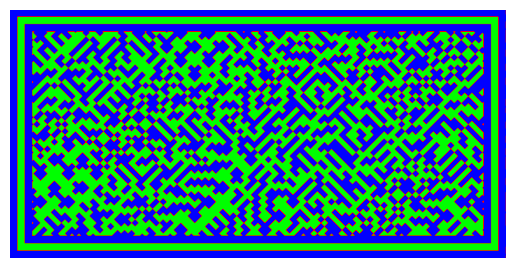

In [7]:
# random carpet
idx = np.random.randint(0,7500)
show_carpet(X_train, idx)
print('Carpet from', oh_to_label(y_train[idx,None])[0])

In [8]:
def loss_batch(model, loss_func, xb, yb, opt=None):

    output=model(xb)
    loss = loss_func(output, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    _, preds = torch.max(output, 1)
    corrects = torch.sum(preds == yb.data)

    return loss.item(), corrects, len(xb)

In [9]:
###     YOUR CODE FOR TASK 1    ###
### ADD MORE CELLS IF NECESSARY ###

import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter


def fit(train_dataset, val_dataset, model, num_epochs, learning_rate=0.001, batch_size=64, device='cuda'):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)

    for epoch in range(num_epochs):


        # Training process
        model.train()

        train_loss = 0.0
        train_correct = 0
        sample_num = 0

        # Loop over taining set
        for X_batch, y_batch in train_loader:
            # Send the input to the device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # Convert one-hot to indices
            y_batch_indices = torch.argmax(y_batch, axis=1)

            losses, corrects, nums = loss_batch(model, criterion, X_batch, y_batch_indices, optimizer)

            # Statistics
            train_correct += corrects
            train_loss += losses
            sample_num += nums

        train_loss /= sample_num
        train_acc = train_correct / sample_num

        # Validation process
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_correct = 0
            sample_num = 0

            # Loop over validation set
            for X_batch, y_batch in val_loader:
                # Send the input to the device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                # Convert one-hot to indices
                y_batch_indices = torch.argmax(y_batch, axis=1)
                losses, corrects, nums = loss_batch(model, criterion, X_batch, y_batch_indices)

                val_correct += corrects
                val_loss += losses * X_batch.size(0)
                sample_num += nums

        val_loss /= sample_num
        val_acc = val_correct / sample_num

        print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Train Acc: {train_acc:.6f}, Val Loss: {val_loss:.6f}, Val Acc: {val_acc:.6f}')

In [20]:
from symconv import Slice, SymmetryConv2d, SymmetryPool

class CarpetNet(nn.Module):
    def __init__(self, n_classes=3):
        super(CarpetNet, self).__init__()

        # unit cell (4-fold rotation), 18 filters (18 different unit cells)
        self.slice4 = Slice(rotation=4, reflection=False)
        self.conv1 = SymmetryConv2d(in_filters=1, out_filters=18, kernel_size=4, stride=4, rotation=4, reflection=False)

        # super cell (1-fold rotation), 12 filters (12 different super cells)
        self.slice1 = Slice(rotation=1, reflection=False)
        self.conv2 = SymmetryConv2d(in_filters=18, out_filters=24, kernel_size=3, stride=3, rotation=1, reflection=False)

        self.relu = nn.ReLU()
        self.pool = SymmetryPool()

        # Classifier head
        self.fc1 = nn.Linear(960, 128)
        self.fc2 = nn.Linear(128, n_classes)
        # self.fc1 = nn.Linear(480, n_classes)

    def forward(self, x):
        # Unit cell level
        x = self.slice4(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Super cell level
        x = self.slice1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        # Classifier head
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [21]:
batch_size = 128
epochs = 15

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

symmetryCNN = CarpetNet()

# train the model
fit(train_dataset, val_dataset, symmetryCNN, num_epochs=epochs,
            learning_rate=0.001, batch_size=batch_size, device=device)

Epoch: 1/15, Train Loss: 0.017470, Train Acc: 0.338667, Val Loss: 1.168209, Val Acc: 0.326500
Epoch: 2/15, Train Loss: 0.008635, Train Acc: 0.387067, Val Loss: 1.069244, Val Acc: 0.430500
Epoch: 3/15, Train Loss: 0.007906, Train Acc: 0.492667, Val Loss: 0.957533, Val Acc: 0.546000
Epoch: 4/15, Train Loss: 0.006539, Train Acc: 0.653733, Val Loss: 0.721057, Val Acc: 0.721000
Epoch: 5/15, Train Loss: 0.003937, Train Acc: 0.831733, Val Loss: 0.303955, Val Acc: 0.912000
Epoch: 6/15, Train Loss: 0.001610, Train Acc: 0.944667, Val Loss: 0.180246, Val Acc: 0.945000
Epoch: 7/15, Train Loss: 0.000761, Train Acc: 0.980533, Val Loss: 0.103267, Val Acc: 0.968000
Epoch: 8/15, Train Loss: 0.000479, Train Acc: 0.988667, Val Loss: 0.072923, Val Acc: 0.982500
Epoch: 9/15, Train Loss: 0.000348, Train Acc: 0.992000, Val Loss: 0.070981, Val Acc: 0.975500
Epoch: 10/15, Train Loss: 0.000287, Train Acc: 0.993067, Val Loss: 0.062163, Val Acc: 0.983000
Epoch: 11/15, Train Loss: 0.000176, Train Acc: 0.997333, Va

In [22]:
# evaluate test accuracy
def evaluate(model, test_data):
  model.eval()
  with torch.no_grad():
    test_correct = 0
    for X_batch, y_batch in test_data:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch_indices = torch.argmax(y_batch, axis=1)  # Convert one-hot to indices

        output = model(X_batch)
        _, predicted = output.max(1)
        test_correct += predicted.eq(y_batch_indices).sum().item()

    test_acc = test_correct / len(test_dataset)
    print(f'Test Acc: {test_acc:.6f}')

In [23]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
evaluate(model=symmetryCNN, test_data=test_loader)

Test Acc: 0.980000


## Task 1: Question 5d

# Task 2: Carpet Matching

In [ ]:
# loading training and testing data for task 2
# DO NOT MODIFY
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
# task2 = np.load('task2data.npz')

X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(float)
gt = task2['arr_2'].astype(float) # ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

print(f"Carpet train shape: {X.shape}")
print(f"Label train shape: {y.shape}")
print(f"Ground truth test shape: {gt.shape}")
print(f"Query carpets shape: {queries.shape}")
print(f"Candidate carpets shape: {targets.shape}")

Carpet train shape: (15000, 1, 96, 60)
Label train shape: (15000,)
Ground truth test shape: (300,)
Query carpets shape: (300, 1, 96, 60)
Candidate carpets shape: (300, 4, 1, 96, 60)


In [ ]:
from symconv import Slice, SymmetryConv2d, SymmetryPool

class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()

        # unit cell (4-fold rotation), 18 filters (18 different unit cells)
        self.slice4 = Slice(rotation=4, reflection=False)
        self.conv1 = SymmetryConv2d(in_filters=1, out_filters=18, kernel_size=4, stride=4, rotation=4, reflection=False)

        # super cell (1-fold rotation), 12 filters (12 different super cells)
        self.slice1 = Slice(rotation=1, reflection=False)
        self.conv2 = SymmetryConv2d(in_filters=18, out_filters=12, kernel_size=3, stride=3, rotation=1, reflection=False)

        self.relu = nn.ReLU()
        self.pool = SymmetryPool()

        # Embedding head
        self.fc1 = nn.Linear(480, 128)

    def forward(self, x):
        # Unit cell level
        x = self.slice4(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Super cell level
        x = self.slice1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        # Classifier head
        x = torch.flatten(x, 1)
        x = self.fc1(x)

        return x

In [ ]:
from torch.utils.data.sampler import BatchSampler
import numpy as np


class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [ ]:
embedding_train = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
embbeding_train_loader = DataLoader(embedding_train, batch_size=1, shuffle=False)

train_batch_sampler = BalancedBatchSampler(y, n_classes=len(np.unique(y)), n_samples=10)
triplets_train_loader = torch.utils.data.DataLoader(embedding_train, batch_sampler=train_batch_sampler)

In [ ]:
from itertools import combinations

class RandomTripletSelector():
    """
    Select random negative example for each positive pair to create triplets
    """

    def __init__(self):
        super(RandomTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # all anchor-positive pairs

            # random choose one negative example for each positive pair
            temp_triplets = [[anchor_positive[0], anchor_positive[1], np.random.choice(negative_indices)] for anchor_positive in anchor_positives]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))

In [ ]:
class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of triplets
    """

    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):
        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()

        anchor_idx = triplets[:, 0]
        positive_idx = triplets[:, 1]
        negative_idx = triplets[:, 2]

        # L(xp, xn, xa) = max(|xa - xp|^2 - |xa - xn|^2 + alpha, 0)
        ap_distances = (embeddings[anchor_idx] - embeddings[positive_idx]).pow(2).sum(1)
        an_distances = (embeddings[anchor_idx] - embeddings[negative_idx]).pow(2).sum(1)
        losses = F.relu(ap_distances - an_distances + self.margin)

        return losses.mean()

In [ ]:
class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset,
                 epochs: int
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs

    def run_trainer(self):
        for epoch in tqdm(range(self.epochs)):

            self.model.train()  # train mode

            train_losses = []
            for batch in self.training_DataLoader:

                x, y = batch
                input, target = x.to(self.device), y.to(
                    self.device)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input)  # one forward pass
                loss = self.criterion(out, target)  # calculate loss

                loss_value = loss.item()
                train_losses.append(loss_value)

                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters

            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}', end=' ')


In [ ]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# model
embedding_net = EmbeddingNet()
model = embedding_net.to(device)

# margin value
margin = 0.001

# criterion
criterion = TripletLoss(margin, RandomTripletSelector())

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=triplets_train_loader,
                  validation_DataLoader=None,
                  epochs=10)

# start training
trainer.run_trainer()

 10%|█         | 1/10 [00:47<07:05, 47.29s/it]

EPOCH: 01/10 LOSS: 758.4117 

 20%|██        | 2/10 [01:23<05:26, 40.80s/it]

EPOCH: 02/10 LOSS: 309.8064 

 30%|███       | 3/10 [01:58<04:28, 38.30s/it]

EPOCH: 03/10 LOSS: 146.7988 

 40%|████      | 4/10 [02:34<03:42, 37.10s/it]

EPOCH: 04/10 LOSS: 73.9714 

 50%|█████     | 5/10 [03:09<03:02, 36.42s/it]

EPOCH: 05/10 LOSS: 40.0092 

 60%|██████    | 6/10 [03:44<02:24, 36.11s/it]

EPOCH: 06/10 LOSS: 22.4257 

 70%|███████   | 7/10 [04:20<01:47, 35.90s/it]

EPOCH: 07/10 LOSS: 13.2695 

 80%|████████  | 8/10 [04:55<01:11, 35.60s/it]

EPOCH: 08/10 LOSS: 8.0249 

 90%|█████████ | 9/10 [05:31<00:35, 35.64s/it]

EPOCH: 09/10 LOSS: 5.1930 

100%|██████████| 10/10 [06:05<00:00, 36.54s/it]

EPOCH: 10/10 LOSS: 3.4302 

In [ ]:
# function to determine performance of model
def query_performance(queries, targets, gt, top=1):
    assert top >= 1
    cnt = 0
    for i in range(gt.shape[0]):

        q = queries[i][None].float().to(device)
        t = targets[i].float().to(device)

        with torch.no_grad():


            ### MODIFY IF NECESSARY ###
            emb_q = trainer.model(q).cpu().numpy()
            emb_t = trainer.model(t).cpu().numpy()


            dists = cdist(emb_q, emb_t)

            if top == 1:
                pred = np.argmin(dists)

                if pred == gt[i]:
                    cnt += 1

            else:
                pred = np.argsort(dists)
                if gt[i] in pred[0,:top].tolist():
                    cnt+=1
    return (100*cnt/gt.shape[0])

In [ ]:
for k in [1,2,3]:
    print(f'Performance for k={k}: {query_performance(torch.tensor(queries), torch.tensor(targets), gt, top=k)}')

Performance for k=1: 86.0
Performance for k=2: 93.66666666666667
Performance for k=3: 97.33333333333333
